<a href="https://colab.research.google.com/github/bragarods/rainfall_forecast/blob/master/notebooks/colab_ts_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (13, 7)

In [2]:
!pip3 install --upgrade tslearn
!pip install --upgrade chart_studio

     |████████████████████████████████| 778kB 10.4MB/s 


## Import monthly data

In [3]:
# google drive shareable file link

orig_url = 'https://drive.google.com/file/d/1WQ9NARYCNZxWlQUAf4Zn5TxJcnOGjEn3/view?usp=sharing'

# get file id

file_id = orig_url.split('/')[-2]

# create download url

dwn_url='https://drive.google.com/uc?export=download&id=' + file_id

# get raw text inside url

url = requests.get(dwn_url).text

# create a buffer

csv_raw = StringIO(url)

# read from buffer

df = pd.read_csv(csv_raw, index_col=0)

df.reset_index(drop=True, inplace=True)

# create sinop and csinop series

df['date'] = pd.to_datetime(df['date'], format=('%Y-%m-%d')) 

#df.set_index('date', inplace=True)

# cut train period

train = df[(df.date >= '2000-01-01') & (df.date <= '2019-12-01')]

test = df[df.date >= '2019-01-01']

## Flag first full year of data

In [4]:
df['chuva_max_12m'] = df.groupby('cd_estacao')['chuva'].rolling(12).max().reset_index(0,drop=True)

df['flag_chuva_max_12m'] = np.where((~df['chuva_max_12m'].isna()) & (df['chuva_max_12m'] >= 1),
                               1,
                               0)

min_year = df[df['flag_chuva_max_12m']==1].groupby('cd_estacao').agg(min_year=('date','min'))['min_year'].dt.year+1

df = pd.merge(df,min_year,how='left',left_on=df.cd_estacao,right_on=min_year.index)

df.drop(columns='key_0', inplace=True)

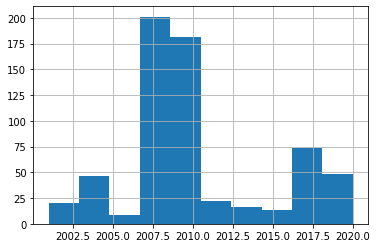

In [5]:
df.drop_duplicates(['cd_estacao']).min_year.hist()

# most of the stations has data avaiable from 2009

## Clustering series

In [6]:
df2009 = df[(df['min_year']<=2009) & (df.date >= '2009-01-01')]

In [7]:
dfp = df2009.set_index('date').pivot(columns=['cd_estacao'], values=['chuva'])
dfp.columns = dfp.columns.droplevel()

In [13]:
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw
from tslearn.utils import to_time_series_dataset


# define seed
seed = 0
np.random.seed(seed)

X, y = dfp[dfp.index<='2018-12-01'], dfp[dfp.index > '2018-12-01']

series = []

for col in dfp.columns:
  series.append(dfp[col])

X_train = to_time_series_dataset([s.values for s in series])

X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

#X_train = X_train[y_train < 4]  # Keep first 3 classes
#numpy.random.shuffle(X_train)
# Keep only 50 time series
#X_train = TimeSeriesScalerMeanVariance().fit_transform(X)
# Make time series shorter
#X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
#sz = X_train.shape[1]

Euclidean k-means
98.699 --> 67.272 --> 64.765 --> 64.295 --> 64.137 --> 64.004 --> 63.820 --> 63.793 --> 63.793 --> 
Cluster 1 6.876752089047024
Cluster 2 6.274469315434589
Cluster 3 9.233636752585298
Cluster 4 5.253152360998208
Cluster 5 7.7431627104869065
Cluster 6 6.001774488956739
Cluster 7 7.083757949022985
Cluster 8 6.99517673911233
Cluster 9 5.573822695236273
Cluster 10 7.304317113168315
Cluster 11 5.368267345987408
Cluster 12 6.393330984320551
Cluster 13 6.357456206717644
Cluster 14 6.529179848427905
Cluster 15 7.089790644550215
Cluster 16 6.39398033314049
Cluster 17 6.261077457170625
Cluster 18 6.057260974302966
Cluster 19 7.053393805991142
Cluster 20 6.753899040789944
Cluster 21 6.191751370346564
Cluster 22 6.9038718535275745
Cluster 23 6.729364673834029
Cluster 24 7.213282348798041
Cluster 25 6.189201007472721


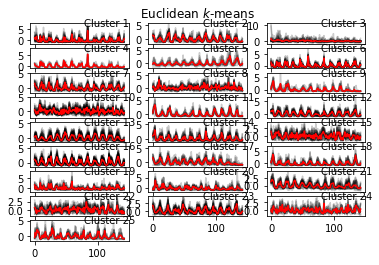

In [27]:
# Euclidean k-means
print("Euclidean k-means")
n_clusters = 25
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure()
for yi in range(n_clusters):
    plt.subplot(round(n_clusters/3)+1, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, X_train.shape[1])
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

for yi in np.arange(0,n_clusters):
  print('Cluster {}'.format(yi+1), cdist_dtw(X_train[y_pred==yi]).mean())

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


584076.669 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


432425.049 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


427137.690 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


424229.270 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


424229.270 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.6s finished


555325.730 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


428975.991 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


428975.991 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


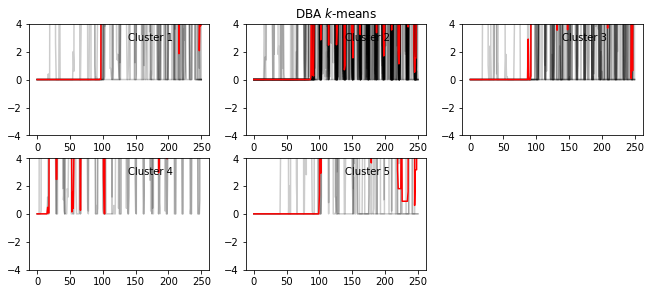

In [ ]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(5):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

Soft-DTW k-means
402107476144.291 --> 228845262320.792 --> 228715719321.222 --> 228614919395.713 --> 228405432541.201 --> 228337463072.049 --> 228178757251.933 --> 228134774892.517 --> 227997181964.666 --> 227963382314.981 --> 227580728441.034 --> 227529437484.235 --> 227493905221.291 --> 227381302478.524 --> 227358674047.171 --> 227291078729.013 --> 227274284559.461 --> 227262282613.917 --> 227252902720.132 --> 227224359845.215 --> 227203365063.163 --> 227123492886.753 --> 227111311054.270 --> 226961959062.693 --> 226939177437.379 --> 226933052357.031 --> 226930021880.422 --> 226928433326.911 --> 226928496757.061 --> 226930005243.465 --> 226933113856.871 --> 226937558170.403 --> 226944875381.419 --> 226943436484.111 --> 226955086761.506 --> 226952331524.125 --> 226954354803.571 --> 226952203159.306 --> 226957614857.439 --> 226955744515.323 --> 226980417392.938 --> 226974464611.521 --> 226979894528.999 --> 226980471535.747 --> 226983186752.057 --> 226983454977.074 --> 226980525913.987 

ValueError: ignored

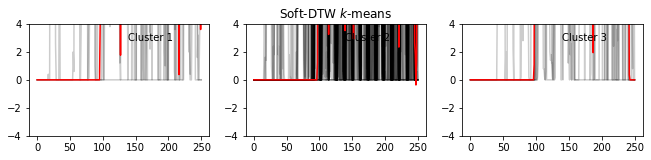

In [ ]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(5):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    #plt.xlim(0, sz)
    #plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()

In [66]:
from tslearn.utils import to_time_series_dataset, to_pyts_dataset

fdf = pd.DataFrame(to_pyts_dataset(X_train))

fdf = fdf.set_index([df2009.drop_duplicates('cd_estacao').cd_estacao, y_pred]).sort_index()

In [72]:
kndf = pd.DataFrame(fdf.index.to_list(), columns=['cd_estacao','kcluster'])

kndf1 = pd.merge(kndf, df2009[['cd_estacao','dc_nome','vl_latitude','vl_longitude']], how='left',left_on='cd_estacao',right_on='cd_estacao')

In [77]:
kndf2 = kndf1.drop_duplicates('cd_estacao').reset_index(drop=True)

In [78]:
kndf2.head()

,cd_estacao,kcluster,dc_nome,vl_latitude,vl_longitude
0,A001,15,brasilia,-15.789343,-47.925756
1,A002,15,goiania,-16.642841,-49.220222
2,A003,15,morrinhos,-17.745066,-49.101698
3,A004,3,niquelandia,-14.469358,-48.485756
4,A005,4,porangatu,-13.309528,-49.117478


## Data on Map

In [50]:
import chart_studio.plotly as py
from plotly.offline import iplot
import plotly.graph_objs as go
import pandas as pd

# Change API key for Plotly 

#tl.set_credentials_file(username='aschrock', api_key='CWwy1WgujKrPK4Z1J0Oh')

# Add Mapbox access token here 

mapbox_access_token = 'pk.eyJ1IjoiYXNjaHJvY2siLCJhIjoiY2p2NnRoeHc2MDkxbTQ0bnR6aTVwZDNsaCJ9.MA76hkxD3rOGgnVCDBVC9w'

#df = pd.read_csv('http://geohub.lacity.org/datasets/259473fbb4b34ff182581f411fe4c918_49.csv')

# Save latitude and longitude as variables. In this dataset, the X column is longitude and the Y column is latitude. 

site_lat = df2009.drop_duplicates('dc_nome').vl_latitude
site_lon = df2009.drop_duplicates('dc_nome').vl_longitude
locations_name = df2009.drop_duplicates('dc_nome').dc_nome

name = 'Estações Inmet - #{}'.format(len(df2009.drop_duplicates('dc_nome').dc_nome))

# Generate the data for the map 

data = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=7,
            color='rgb(255, 0, 0)',
            opacity=1
        )
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=13,
            color='rgb(242, 177, 172)',
            opacity=0.8
        ),
        text=locations_name,
        hoverinfo='text'
    )]


# Generate a layout around Los Angeles, zoomed in so we can see the data points 

layout = go.Layout(
    title=name,
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=-15.789343,
            lon=-47.925756
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)
	
# Generate the figure using the iplot function 
  
fig = dict(data=data, layout=layout)
iplot(fig, filename=name)